# บทที่ 6n - การเทรนโมเดลบน Hugging Face พาร์ท 2.2

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/ai-builders/curriculum/blob/main/notebooks/06n_Question_Answering.ipynb)


In [ ]:
!pip install datasets==1.17.0 transformers[sentencepiece]==4.34.0
!pip install accelerate==0.23.0
# To run the training on TPU, you will need to uncomment the followin line:
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs

     |████████████████████████████████| 306 kB 5.3 MB/s 
     |████████████████████████████████| 3.4 MB 39.5 MB/s 
     |████████████████████████████████| 212 kB 31.8 MB/s 
     |████████████████████████████████| 1.1 MB 23.0 MB/s 
     |████████████████████████████████| 77 kB 6.2 MB/s 
     |████████████████████████████████| 136 kB 46.3 MB/s 
     |████████████████████████████████| 3.3 MB 33.7 MB/s 
     |████████████████████████████████| 880 kB 33.4 MB/s 
     |████████████████████████████████| 596 kB 31.6 MB/s 
     |████████████████████████████████| 1.2 MB 30.3 MB/s 
     |████████████████████████████████| 271 kB 15.7 MB/s 
     |████████████████████████████████| 144 kB 36.1 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=15785a1f0e8f012298b31dc769acc82864d450cb00bc4e316327a92d73adf72a
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d66029

In [ ]:
!git config --global user.email "pingloaf@gmail.com"
!git config --global user.name "mrp"

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


# โจทย์วันนี้: สร้างระบบถามตอบ!!

In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset("squad") # dataset ยอดฮิต

Downloading:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/8.12M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset squad downloaded and prepared to /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

# องค์ประกอบ
ในดาต้าเซ็ตจะประกอบด้วย 
* title: หัวข้อหรือชื่อเอกสารของ context
* context: ประโยคที่เกี่ยวข้องกับคำถาม
* question: คำถามที่ถูกสร้างขึ้นจาก context
* answer: ตำแหน่งของคำตอบที่อยู่ใน context



In [ ]:
raw_datasets 

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

In [ ]:
print("Context: ", raw_datasets["train"][0]["context"]) # ประโยคทั่วไป
print("Question: ", raw_datasets["train"][0]["question"]) # คำถามที่แต่งจากประโยคทั่วไป
print("Answer: ", raw_datasets["train"][0]["answers"]) # คำตอบของคำถาม

Context:  Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
Question:  To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Answer:  {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}


In [ ]:
raw_datasets["train"].filter(lambda x: len(x["answers"]["text"]) != 1) # และในบางครั้งคำตอบก็มีได้มากกว่า 1 (เช่น ชื่อสถานที่ จะชื่อเต็มหรือชื่อย่อก็เป็นคำตอบเหมือนกัน)

  0%|          | 0/88 [00:00<?, ?ba/s]

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 0
})

In [ ]:
print(raw_datasets["validation"][0]["answers"])
print(raw_datasets["validation"][2]["answers"])

{'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'], 'answer_start': [177, 177, 177]}
{'text': ['Santa Clara, California', "Levi's Stadium", "Levi's Stadium in the San Francisco Bay Area at Santa Clara, California."], 'answer_start': [403, 355, 355]}


In [ ]:
print(raw_datasets["validation"][2]["context"])
print(raw_datasets["validation"][2]["question"]) # Santa Clara, California หรือ Levi's Stadium ก็เป็นคำตอบได้

Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.
Where did Super Bowl 50 take place?


In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

# จัด Format แบบที่เราต้องการ: "[CLS] question [SEP] context [SEP]"
* [CLS] เป็น token พิเศษที่เป็นการรวมกันของ question และ context (เอาไว้ดู global information)
* [SEP] separate token เอาไว้กั้นระหว่าง question กับ context เฉยๆ



In [ ]:
context = raw_datasets["train"][0]["context"]
question = raw_datasets["train"][0]["question"]

inputs = tokenizer(question, context)
tokenizer.decode(inputs["input_ids"])

'[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive ( and in a direct line that connects through 3 statues and the Gold Dome ), is a simple, modern stone statue of Mary. [SEP]'

# จัดการเฉลย
ยกตัวอย่างเช่น:

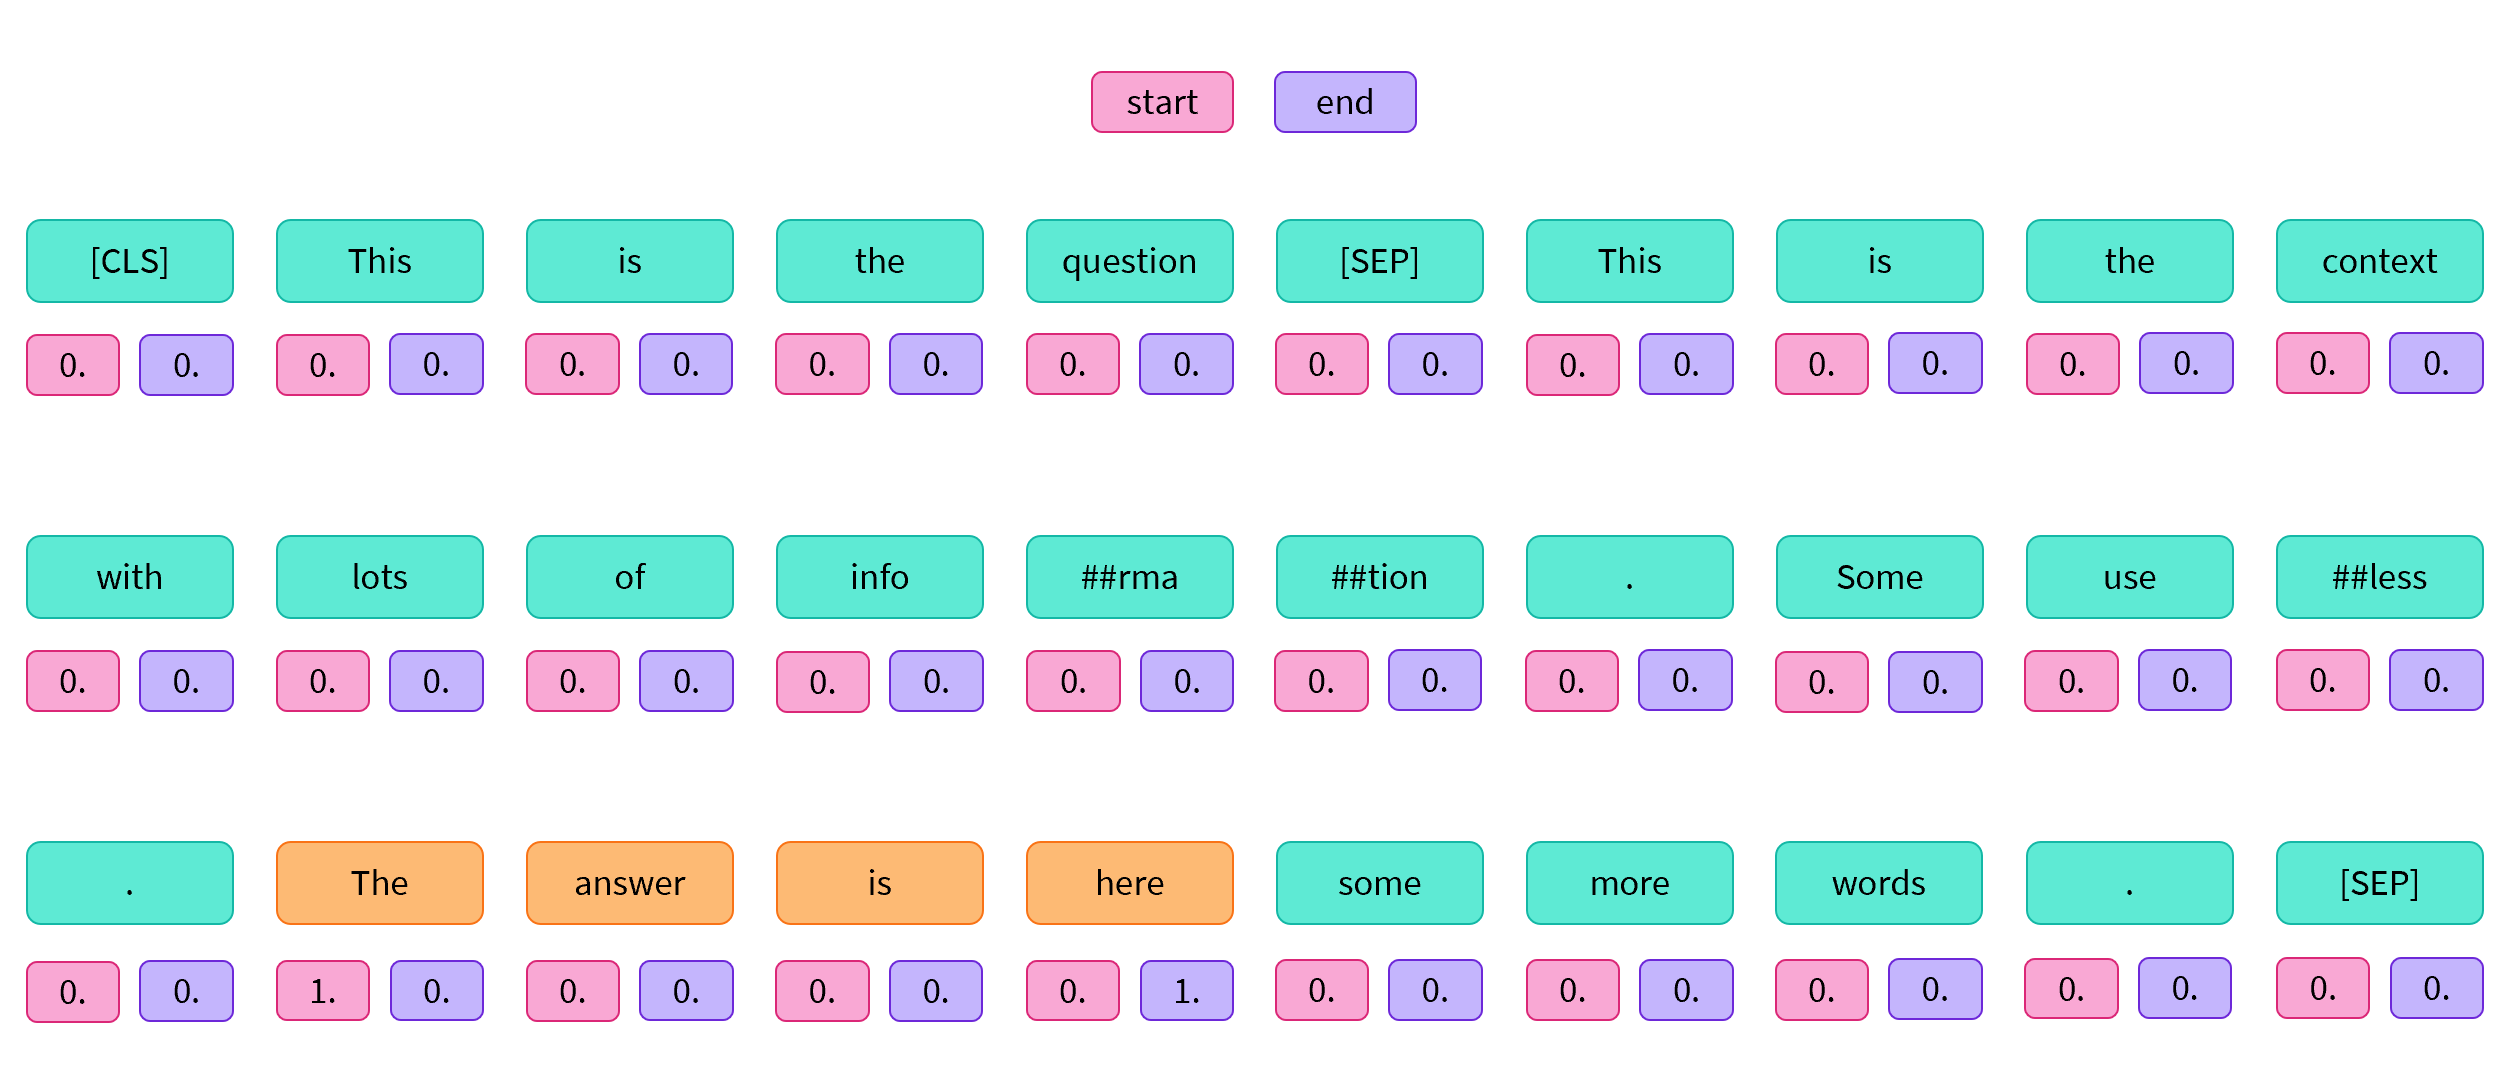

จากบทเรียนก่อนหน้าที่เราพบว่า "ประโยคยาวเกินไป" ซึ่งปัญหานี้มักจะเกิดบน context บ่อยมาก ซึ่งมักจะเกิน maximum length (จากในกรณีนี้คือ 384 คำ) 

ซึ่งจากบทเรียนก่อนหน้าเราก็ใช้วิธีแบ่งเป็นก้อนๆ โดยรอบนี้เราจะแบ่งก้อนละ 100 คำ และค่อยๆขยับทีละ 50 คำ (หลักการของ [N-gram](https://kavita-ganesan.com/what-are-n-grams/); โดยที่ N = 50) โดยที่ทั้งหมดนี้ Hugging Face ก็มีไว้ให้หมดแล้วนั้นคือคำสั่ง truncation="only_second" และ stride=50

In [ ]:
inputs = tokenizer(
    question,
    context,
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
)

for ids in inputs["input_ids"]:
    print(tokenizer.decode(ids)) # จะเห็นว่าประโยคที่สองคือการตัดมาจากอันแรก

[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basi [SEP]
[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin [SEP]
[CLS] To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France? [SEP] Next to the Main Building is the B

# แล้ว Answer จะทำยังไง?
= จากตัวอย่างนี้จะพบว่าคำตอบของคำถาม (“Bernadette Soubirous") จะปรากฏแค่ประโยคที่ 3 และ 4 แล้วจะทำยังไงดีละ?

เมื่อประโยคที่ถูกตัดมาไม่มีคำตอบ เราจะเซ็ตให้ start_position กับ end_position (จากรูปก่อนหน้า) กลายเป็น 0 ทั้งหมด และสำหรับประโยคไหนที่มีคำตอบ เราจะทำการเปลี่ยนจาก 0 เป็น index ของคำตอบนั้นเอง

In [ ]:
inputs = tokenizer(
    question,
    context,
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True, 
    return_offsets_mapping=True,
)
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping'])

## overflow_to_sample_mapping?
= ตรงนี้หลังจากที่เราแบ่งเป็นก้อนๆแล้ว ตัวตัดคำเราจะบอกด้วยว่า ก้อนไหนเป็นของประโยคที่เท่าไหร่บ้าง ซึ่งมีประโยชน์มากๆ เพราะเราจะรู้ว่าก้อนไหนมาจากประโยคไหนบ้าง

In [ ]:
inputs['overflow_to_sample_mapping'] 

[0, 0, 0, 0]

In [ ]:
inputs = tokenizer(
    raw_datasets["train"][2:6]["question"],
    raw_datasets["train"][2:6]["context"],
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
)

print(f"The 4 examples gave {len(inputs['input_ids'])} features.")
print(f"Here is where each comes from: {inputs['overflow_to_sample_mapping']}.")

The 4 examples gave 19 features.
Here is where each comes from: [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3].


จากตัวอย่างนี้จะเห็นว่า เราส่งให้ตัวตัดคำตัดไป 4 ประโยค เมื่อโดนแบ่งมาเรียบร้อยแล้ว ตัวตัดคำของเราจะบอกด้วยว่าก้อนไหนเป็นของประโยคไหน (ซึ่งแต่ละประโยคก็มีความยาวไม่เท่ากัน สังเกตุจากตัวเลขแต่ละประโยคแทบจะไม่เท่ากัน)

จากนั้นเมื่อเรารู้ว่าก้อนไหนมาจากไหนแล้ว เราก็ทำการแมพคำตอบไปที่ก้อนนั้นๆได้ โดยหน้าตาของเฉลยของเราจะเป็น
* ถ้าก้อนไหนมีคำตอบ: (start_position, end_position) โดยที่ start จะเป็นตำแหน่งเริ่มต้นของคำที่เป็นคำตอบและ end จะเป็นตำแหน่งของคำสุดท้ายของคำตอบ
* ถ้าก้อนไหนไม่มีคำตอบ: (0,0) 

In [ ]:
answers = raw_datasets["train"][2:6]["answers"]
start_positions = []
end_positions = []

for i, offset in enumerate(inputs["offset_mapping"]):
    sample_idx = inputs["overflow_to_sample_mapping"][i]
    answer = answers[sample_idx]
    start_char = answer["answer_start"][0]
    end_char = answer["answer_start"][0] + len(answer["text"][0])
    sequence_ids = inputs.sequence_ids(i)

    # Find the start and end of the context
    idx = 0
    while sequence_ids[idx] != 1:
        idx += 1
    context_start = idx
    while sequence_ids[idx] == 1:
        idx += 1
    context_end = idx - 1

    # If the answer is not fully inside the context, label is (0, 0)
    if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
        start_positions.append(0)
        end_positions.append(0)
    else:
        # Otherwise it's the start and end token positions
        idx = context_start
        while idx <= context_end and offset[idx][0] <= start_char:
            idx += 1
        start_positions.append(idx - 1)

        idx = context_end
        while idx >= context_start and offset[idx][1] >= end_char:
            idx -= 1
        end_positions.append(idx + 1)

start_positions, end_positions # ตรงนี้จะเห็นว่า 83-85 เป็นตำแหน่งของคำตอบในก้อนแรกนั้นเอง!! 

([83, 51, 19, 0, 0, 64, 27, 0, 34, 0, 0, 0, 67, 34, 0, 0, 0, 0, 0],
 [85, 53, 21, 0, 0, 70, 33, 0, 40, 0, 0, 0, 68, 35, 0, 0, 0, 0, 0])

In [ ]:
tokenizer.decode(inputs['input_ids'][0])

'[CLS] The Basilica of the Sacred heart at Notre Dame is beside to which structure? [SEP] Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basi [SEP]'

In [ ]:
tokenizer.decode(inputs['input_ids'][0][83:86])

'the Main Building'

In [ ]:
raw_datasets["train"][2]

{'answers': {'answer_start': [279], 'text': ['the Main Building']},
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'id': '5733be284776f41900661180',
 'question': 'The Basilica of the Sacred heart at Notre Dame is beside to which structure?',
 'title': 'University_of_Notre_Dame'}

# Answer check

In [ ]:
idx = 0
sample_idx = inputs["overflow_to_sample_mapping"][idx]
answer = answers[sample_idx]["text"][0]

start = start_positions[idx]
end = end_positions[idx]
labeled_answer = tokenizer.decode(inputs["input_ids"][idx][start : end + 1])

print(f"Theoretical answer: {answer}, labels give: {labeled_answer}") # เช็คให้ชัวร์ด้วยว่าตรงกันมั้ยยยย

Theoretical answer: the Main Building, labels give: the Main Building


เมื่อเช็คแล้วว่าคำตอบของเรานั้นแมพได้ถูกต้อง จากนั้นให้มาเช็คว่าในกรณีที่ไม่มีคำตอบ ตัวคำตอบของเราควรจะตอบเป็นประโยคเดิมกลับคืน

In [ ]:
idx = 4
sample_idx = inputs["overflow_to_sample_mapping"][idx]
answer = answers[sample_idx]["text"][0]

decoded_example = tokenizer.decode(inputs["input_ids"][idx])
print(f"Theoretical answer: {answer}, decoded example: {decoded_example}")

Theoretical answer: a Marian place of prayer and reflection, decoded example: [CLS] What is the Grotto at Notre Dame? [SEP] Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend " Venite Ad Me Omnes ". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grot [SEP]


In [ ]:
max_length = 384
stride = 128


def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [ ]:
train_dataset = raw_datasets["train"].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)
len(raw_datasets["train"]), len(train_dataset) # ทำการตัดคำทั้งหมดพร้อมทั้งแบ่งเป็นก้อนๆ

  0%|          | 0/88 [00:00<?, ?ba/s]

(87599, 88729)

In [ ]:
train_dataset

Dataset({
    features: ['attention_mask', 'end_positions', 'input_ids', 'start_positions', 'token_type_ids'],
    num_rows: 88729
})

In [ ]:
def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs


In [ ]:
validation_dataset = raw_datasets["validation"].map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)
len(raw_datasets["validation"]), len(validation_dataset)

  0%|          | 0/11 [00:00<?, ?ba/s]

(10570, 10822)

In [ ]:
validation_dataset # ไม่ต้องมีตำแหน่งเริ่ม-จบ เพราะโมเดลจะต้องทำนายของพวกนี้เอง!!

Dataset({
    features: ['attention_mask', 'example_id', 'input_ids', 'offset_mapping', 'token_type_ids'],
    num_rows: 10822
})

# ทริคพิเศษ (2): ให้โมเดลที่มีอยู่แล้วมาช่วยทำนายคู่ของ start, end



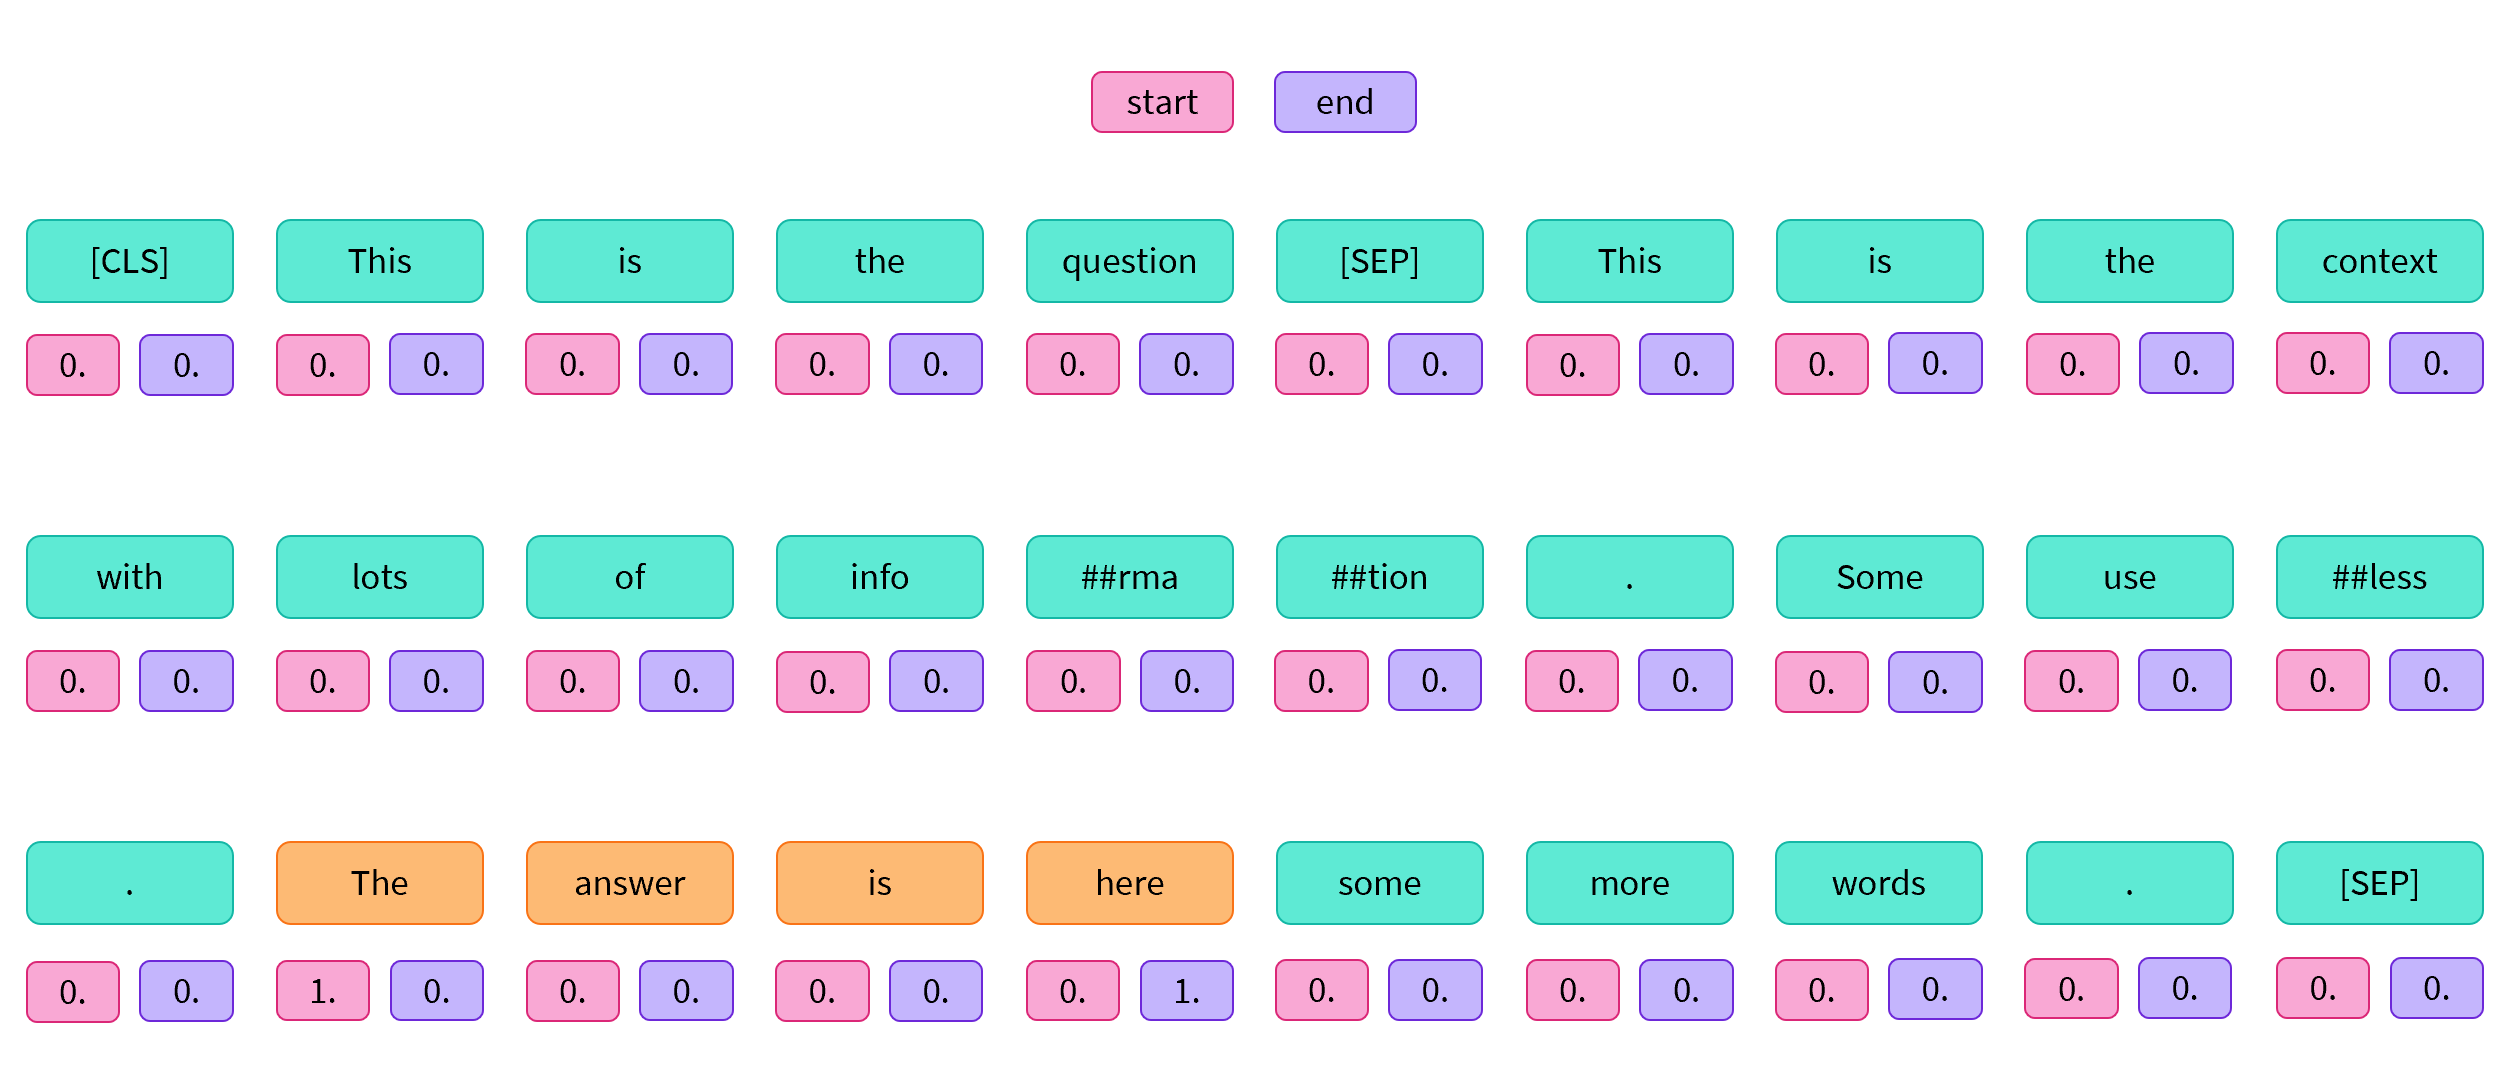

ปกติแล้วในการทำนายโมเดลจะต้องดูว่า start กับ end ที่กำลังจะทำนาย (เป็นคู่กัน) มีความเป็นไปได้สูงสุดหรือไม่ ซึ่งถ้าจะให้ได้คำตอบที่ดีที่สุดโมเดลจะมองหาทุกๆคำตอบที่เป็นไปได้ ซึ่งจะช้ามาก

ซึ่งในครั้งนี้เราจะให้โมเดลอื่นมาช่วยทำนายสกอร์ของแต่ละคู่ไว้ก่อนเลย ซึ่งจะประหยัดเวลาในการเทรนมาก 

เช่น start=1, end=3 ความเป็นไปได้ของคำตอบ = 40% แต่ start=1, end=5 ความเป็นไปได้อาจจะเป็น = 95%!! ซึ่งการจะคำนวณทุกๆความเป็นไปได้มันใช้ทรัพยากรจำนวนมาก เพราะฉนั้นถ้าเราเอาความเป็นไปได้มาจากโมเดลอื่นๆมาช่วยตรงนี้ก็จะประหยัดเวลาเรามาก

In [ ]:
small_eval_set = raw_datasets["validation"].select(range(100)) # ดาต้าขนาดเล็กก็พอแล้ว
trained_checkpoint = "distilbert-base-cased-distilled-squad" # โมเดลที่เทรนมาเรียบร้อยแล้ว

tokenizer = AutoTokenizer.from_pretrained(trained_checkpoint)
eval_set = small_eval_set.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=raw_datasets["validation"].column_names,
)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/473 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint) # เอาตัวตัดคำอันเดิมกลับมา

In [ ]:
import torch
from transformers import AutoModelForQuestionAnswering

eval_set_for_model = eval_set.remove_columns(["example_id", "offset_mapping"])
eval_set_for_model.set_format("torch")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch = {k: eval_set_for_model[k].to(device) for k in eval_set_for_model.column_names}
trained_model = AutoModelForQuestionAnswering.from_pretrained(trained_checkpoint).to(
    device
)

with torch.no_grad():
    outputs = trained_model(**batch) # ได้คู่ของ start,end ที่มาจากโมเดลที่เทรนมาเรียบร้อยแล้ว!

Downloading:   0%|          | 0.00/249M [00:00<?, ?B/s]

In [ ]:
start_logits = outputs.start_logits.cpu().numpy()
end_logits = outputs.end_logits.cpu().numpy() # เอาออกจาก gpu เพราะว่าแค่เอาเลขมาเทียบ ไม่จำเป็นต้องลง gpu

In [ ]:
outputs.start_logits

tensor([[ -2.2607,  -5.1783,  -5.2709,  ...,  -9.5243,  -9.5183,  -9.5288],
        [ -2.5961,  -5.5482,  -5.5313,  ...,  -9.9598,  -9.9533,  -9.9860],
        [ -3.7127,  -7.1848,  -8.5388,  ..., -11.6557, -11.6571, -11.6505],
        ...,
        [ -2.0260,  -4.4167,  -4.4980,  ...,  -8.1479,  -8.1530,  -8.1760],
        [ -4.1553,  -5.8304,  -7.1643,  ..., -10.5255, -10.5251, -10.4890],
        [ -3.2000,  -5.8162,  -6.7249,  ...,  -9.4935,  -9.5038,  -9.4871]],
       device='cuda:0')

In [ ]:
outputs.start_logits[0].shape

torch.Size([384])

In [ ]:
outputs.start_logits[0]

tensor([-2.2607, -5.1783, -5.2709, -6.0859, -6.4507, -6.2671, -5.3146, -6.3033,
        -6.0470, -7.3009, -5.6779, -3.7499, -4.7882, -0.3857, -4.3966, -1.9305,
        -5.3771, -4.3886, -2.5400, -4.3524, -4.3880, -4.3324, -4.6791, -3.5798,
        -2.3069, -6.5530, -2.7710, -0.8722, -3.0605, -2.9521, -4.1955, -1.3517,
        -3.7251, -4.7030, -4.0688, -0.8678, -3.6669, -1.8827,  4.4005,  2.9438,
        -0.7979, -1.3879, -0.6945,  1.5781, -1.7355,  0.5224, 10.6944,  4.4600,
        -1.3704, -0.0497,  2.0126, -2.6718, -2.2984, -1.5135,  0.0207, -2.7324,
        -0.0280,  9.8037,  2.7017, -1.8933, -6.2242, -3.2045, -3.9968, -4.2383,
        -3.5693, -2.5027, -4.0113, -5.9969, -4.7758, -2.7714, -2.5308, -4.8725,
        -6.4015, -4.8849, -5.1912, -3.1706, -4.8221, -6.6688, -1.9079, -5.5711,
        -5.5317, -2.5101, -6.9493, -6.8109, -5.1079, -6.9908, -6.3307, -4.7778,
        -6.5314, -6.4361, -6.0640, -7.3002, -4.8981, -5.9094, -7.5248, -4.0945,
        -5.6986, -6.2753, -5.6613, -8.31

In [ ]:
eval_set[0].keys()

dict_keys(['attention_mask', 'example_id', 'input_ids', 'offset_mapping'])

In [ ]:
tokenizer.decode(eval_set[0]['input_ids'])

'[CLS] Which NFL team represented the AFC at Super Bowl 50? [SEP] Super Bowl 50 was an American football game to determine the champion of the National Football League ( NFL ) for the 2015 season. The American Football Conference ( AFC ) champion Denver Broncos defeated the National Football Conference ( NFC ) champion Carolina Panthers 24 – 10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the " golden anniversary " with various gold - themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals ( under which the game would have been known as " Super Bowl L " ), so that the logo could prominently feature the Arabic numerals 50. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [ ]:
outputs.start_logits[0].argmax(),outputs.end_logits[0].argmax()

(tensor(46, device='cuda:0'), tensor(47, device='cuda:0'))

In [ ]:
tokenizer.decode(eval_set[0]['input_ids'][46:48])

'Denver Broncos'

In [ ]:
raw_datasets["validation"][0]

{'answers': {'answer_start': [177, 177, 177],
  'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos']},
 'context': 'Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi\'s Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.',
 'id': '56be4db0acb8001400a502ec',
 'question': 'Which NFL team represented the AFC at Super Bo

ขั้นถัดไป นำคำตอบที่ได้จากก่อนหน้ามาให้โมเดลที่เรากำลังสนใจจะเทรน หาคำตอบว่าจริงๆแล้วคู่ไหนคือคำตอบจริงๆกันแน่

In [ ]:
import collections

example_to_features = collections.defaultdict(list)
for idx, feature in enumerate(eval_set):
    example_to_features[feature["example_id"]].append(idx)

โดยในขั้นนี้เราสามารถ preprocess คำตอบจากโมเดลอื่นๆได้ เพื่อให้โมเดลของเราดีขึ้นเช่น
* คำตอบที่ความเป็นไปได้ติดลบ
* คำตอบที่ไม่อยู่ใน context ของเรา (เพราะเราแบ่งเป็นก้อนๆแล้ว ถ้าไม่อยู่ในก้อนนี้แสดงว่าก้อนนี้อาจจะไม่มีคำตอบเลยก็ได้)
* คำตอบที่ยาวเกินไป

จากนั้นนำเอาคำตอบที่กรองมาแล้วมา map เข้ากับ input ได้เลย

In [ ]:
import numpy as np

n_best = 20
max_answer_length = 30
predicted_answers = []

for example in small_eval_set:
    example_id = example["id"]
    context = example["context"]
    answers = []

    for feature_index in example_to_features[example_id]:
        start_logit = start_logits[feature_index]
        end_logit = end_logits[feature_index]
        offsets = eval_set["offset_mapping"][feature_index]

        start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
        end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
        for start_index in start_indexes:
            for end_index in end_indexes:
                # Skip answers that are not fully in the context
                if offsets[start_index] is None or offsets[end_index] is None:
                    continue
                # Skip answers with a length that is either < 0 or > max_answer_length.
                if (
                    end_index < start_index
                    or end_index - start_index + 1 > max_answer_length
                ):
                    continue

                answers.append(
                    {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                )

    best_answer = max(answers, key=lambda x: x["logit_score"])
    predicted_answers.append({"id": example_id, "prediction_text": best_answer["text"]})

In [ ]:
from datasets import load_metric

metric = load_metric("squad") # โหลด F1 กับ exact match มา


Downloading:   0%|          | 0.00/1.73k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

In [ ]:
theoretical_answers = [ 
    {"id": ex["id"], "answers": ex["answers"]} for ex in small_eval_set
]

In [ ]:
print(predicted_answers[0])
print(theoretical_answers[0])

{'id': '56be4db0acb8001400a502ec', 'prediction_text': 'Denver Broncos'}
{'id': '56be4db0acb8001400a502ec', 'answers': {'text': ['Denver Broncos', 'Denver Broncos', 'Denver Broncos'], 'answer_start': [177, 177, 177]}}


In [ ]:
metric.compute(predictions=predicted_answers, references=theoretical_answers)

{'exact_match': 83.0, 'f1': 88.25000000000004}

In [ ]:
from tqdm.auto import tqdm


def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [{"id": ex["id"], "answers": ex["answers"]} for ex in examples]
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

In [ ]:
compute_metrics(start_logits, end_logits, eval_set, small_eval_set)

  0%|          | 0/100 [00:00<?, ?it/s]

{'exact_match': 83.0, 'f1': 88.25000000000004}

# Fine-tuning the model

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForQuestionAnswering: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and a

In [ ]:
model

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [ ]:
from transformers import TrainingArguments

args = TrainingArguments(
    "bert-finetuned-squad",
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=2e-5,
    num_train_epochs=1,
    weight_decay=0.01,
    fp16=True,
    push_to_hub=True,
)


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
trainer.train()

/content/bert-finetuned-squad is already a clone of https://huggingface.co/mrp/bert-finetuned-squad. Make sure you pull the latest changes with `repo.git_pull()`.
Using amp half precision backend
***** Running training *****
  Num examples = 88729
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 11092


Step,Training Loss
500,2.606100
1000,1.601400
1500,1.459000
2000,1.366100
2500,1.296400
3000,1.223800
3500,1.251100
4000,1.206600
4500,1.195000
5000,1.122000


Saving model checkpoint to bert-finetuned-squad/checkpoint-11092
Configuration saved in bert-finetuned-squad/checkpoint-11092/config.json
Model weights saved in bert-finetuned-squad/checkpoint-11092/pytorch_model.bin
tokenizer config file saved in bert-finetuned-squad/checkpoint-11092/tokenizer_config.json
Special tokens file saved in bert-finetuned-squad/checkpoint-11092/special_tokens_map.json
tokenizer config file saved in bert-finetuned-squad/tokenizer_config.json
Special tokens file saved in bert-finetuned-squad/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=11092, training_loss=1.2349410485241157, metrics={'train_runtime': 2906.4467, 'train_samples_per_second': 30.528, 'train_steps_per_second': 3.816, 'total_flos': 1.7388449946321408e+16, 'train_loss': 1.2349410485241157, 'epoch': 1.0})

In [ ]:
trainer.push_to_hub(commit_message="Training complete")

Saving model checkpoint to bert-finetuned-squad
Configuration saved in bert-finetuned-squad/config.json
Model weights saved in bert-finetuned-squad/pytorch_model.bin
tokenizer config file saved in bert-finetuned-squad/tokenizer_config.json
Special tokens file saved in bert-finetuned-squad/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.39k/411M [00:00<?, ?B/s]

Upload file runs/Jan20_07-44-31_84a37d15f7ae/events.out.tfevents.1642664677.84a37d15f7ae.74.2:  49%|####9     …

To https://huggingface.co/mrp/bert-finetuned-squad
   a036cc2..fa61df7  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Question Answering', 'type': 'question-answering'}, 'dataset': {'name': 'squad', 'type': 'squad', 'args': 'plain_text'}}
To https://huggingface.co/mrp/bert-finetuned-squad
   fa61df7..0ed7636  main -> main



'https://huggingface.co/mrp/bert-finetuned-squad/commit/fa61df7b8d12697f679620b8e1dce78b72f657d0'

In [ ]:
from transformers import pipeline

# Replace this with your own checkpoint
model_checkpoint = "mrp/bert-finetuned-squad"
question_answerer = pipeline("question-answering", model=model_checkpoint)

context = """
🤗 Transformers is backed by the three most popular deep learning libraries — Jax, PyTorch and TensorFlow — with a seamless integration
between them. It's straightforward to train your models with one before loading them for inference with the other.
"""
question = "Which deep learning libraries back 🤗 Transformers?"
question_answerer(question=question, context=context)

loading configuration file https://huggingface.co/mrp/bert-finetuned-squad/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/463982a8b5ededbbdbd86cbaa84429f78ec71b9b3b212e2205c7cb3c0c08a6e8.029851dbc32bfad1ff275a0602b1e48b1982cef103a3a47181b98f219f636a88
Model config BertConfig {
  "_name_or_path": "mrp/bert-finetuned-squad",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.15.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading confi

{'answer': 'Jax, PyTorch and TensorFlow',
 'end': 105,
 'score': 0.8922150731086731,
 'start': 78}

# โจทย์พิเศษ: Question-Asnwering ภาษาไทย
โดยจะต้องเติมโค้ดลงในช่องว่างให้ถูกต้อง หากทำถูกก็จะแสดงผลเหมือนกับตัวอย่างที่แสดง

In [ ]:
!pip -q install -Uqq datasets pythainlp==2.2.4 transformers==4.4.0 tensorflow==2.4.0 tensorflow_text emoji seqeval sentencepiece fuzzywuzzy
!npx degit --force https://github.com/vistec-AI/thai2transformers#dev

     |████████████████████████████████| 325 kB 11.8 MB/s 
     |████████████████████████████████| 8.9 MB 33.5 MB/s 
     |████████████████████████████████| 2.1 MB 25.9 MB/s 
     |████████████████████████████████| 394.7 MB 18 kB/s 
     |████████████████████████████████| 4.9 MB 36.3 MB/s 
     |████████████████████████████████| 175 kB 49.0 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 1.2 MB 41.0 MB/s 
     |████████████████████████████████| 965 kB 41.7 MB/s 
     |████████████████████████████████| 3.3 MB 35.1 MB/s 
     |████████████████████████████████| 895 kB 45.6 MB/s 
     |████████████████████████████████| 3.8 MB 33.6 MB/s 
     |████████████████████████████████| 2.9 MB 34.7 MB/s 
     |████████████████████████████████| 462 kB 38.0 MB/s 
     |████████████████████████████████| 132 kB 51.7 MB/s 
     |████████████████████████████████| 14.8 MB 35.3 MB/s 
     |████████████████████████████████| 1.1 MB 45.5 MB/s 
     |█████████

In [ ]:
%load_ext autoreload
%autoreload 2

import pythainlp, transformers
pythainlp.__version__, transformers.__version__ #fix pythainlp to stabilize word tokenization for metrics

('2.2.4', '4.4.0')

In [ ]:
import collections
import logging
import pprint
import re
from tqdm.auto import tqdm

import numpy as np
import torch

#datasets
from datasets import (
    load_dataset, 
    load_metric, 
    concatenate_datasets,
    load_from_disk,
)

#transformers
from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForQuestionAnswering,
    TrainingArguments,
    Trainer,
    default_data_collator,
)

#thai2transformers
import thai2transformers
from thai2transformers.metrics import (
    squad_newmm_metric,
    question_answering_metrics,
)
from thai2transformers.preprocess import (
    prepare_qa_train_features
)
from thai2transformers.tokenizers import (
    ThaiRobertaTokenizer,
    ThaiWordsNewmmTokenizer,
    ThaiWordsSyllableTokenizer,
    FakeSefrCutTokenizer,
    SEFR_SPLIT_TOKEN
)

In [ ]:
model_names = [
    'wangchanberta-base-att-spm-uncased',
    'xlm-roberta-base',
    'bert-base-multilingual-cased',
    'wangchanberta-base-wiki-newmm',
    'wangchanberta-base-wiki-ssg',
    'wangchanberta-base-wiki-sefr',
    'wangchanberta-base-wiki-spm',
]

tokenizers = {
    'wangchanberta-base-att-spm-uncased': AutoTokenizer,
    'xlm-roberta-base': AutoTokenizer,
    'bert-base-multilingual-cased': AutoTokenizer,
    'wangchanberta-base-wiki-newmm': ThaiWordsNewmmTokenizer,
    'wangchanberta-base-wiki-ssg': ThaiWordsSyllableTokenizer,
    'wangchanberta-base-wiki-sefr': FakeSefrCutTokenizer,
    'wangchanberta-base-wiki-spm': ThaiRobertaTokenizer,
    
}
public_models = ['xlm-roberta-base', 'bert-base-multilingual-cased'] 
#@title Choose Pretrained Model
model_name = "wangchanberta-base-att-spm-uncased" #@param ["wangchanberta-base-att-spm-uncased", "xlm-roberta-base", "bert-base-multilingual-cased", "wangchanberta-base-wiki-newmm", "wangchanberta-base-wiki-syllable", "wangchanberta-base-wiki-sefr", "wangchanberta-base-wiki-spm"]

#create tokenizer
tokenizer = tokenizers[model_name].from_pretrained(
                f'airesearch/{model_name}' if model_name not in public_models else f'{model_name}',
                revision='main',
                model_max_length=416,)

Downloading:   0%|          | 0.00/546 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/905k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/282 [00:00<?, ?B/s]

# Load dataset

In [ ]:
#parameterizing columns
CONTEXT_COL = 'context'
QUESTION_COL = 'question'
ANSWERS_COL = 'answers'
TEXT_COL = 'text'
START_COL = 'answer_start'
END_COL = 'answer_end'
QUESTION_ID_COL = 'question_id'

In [ ]:
!wget https://archive.org/download/iapp_thaiqa/iapp_thaiqa.zip

--2022-04-03 05:10:26--  https://archive.org/download/iapp_thaiqa/iapp_thaiqa.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia601800.us.archive.org/19/items/iapp_thaiqa/iapp_thaiqa.zip [following]
--2022-04-03 05:10:27--  https://ia601800.us.archive.org/19/items/iapp_thaiqa/iapp_thaiqa.zip
Resolving ia601800.us.archive.org (ia601800.us.archive.org)... 207.241.227.70
Connecting to ia601800.us.archive.org (ia601800.us.archive.org)|207.241.227.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 318808632 (304M) [application/zip]
Saving to: ‘iapp_thaiqa.zip’

iapp_thaiqa.zip     100%[===================>] 304.04M   844KB/s    in 12m 0s  

2022-04-03 05:22:28 (432 KB/s) - ‘iapp_thaiqa.zip’ saved [318808632/318808632]



In [ ]:
!unzip iapp_thaiqa.zip

Archive:  iapp_thaiqa.zip
   creating: iapp_thaiqa/
   creating: iapp_thaiqa/train/
  inflating: iapp_thaiqa/train/cache-8cfe6fc0fc5958b2.arrow  
  inflating: iapp_thaiqa/train/cache-688f37b8d9e8a691.arrow  
  inflating: iapp_thaiqa/train/cache-e3bc363ebe4e6a5f.arrow  
  inflating: iapp_thaiqa/train/state.json  
  inflating: iapp_thaiqa/train/dataset_info.json  
  inflating: iapp_thaiqa/train/cache-77825e7377c5279f.arrow  
  inflating: iapp_thaiqa/train/cache-c10e4fd19ae5bf88.arrow  
  inflating: iapp_thaiqa/train/cache-c38b8c8ad48dea5d.arrow  
  inflating: iapp_thaiqa/train/cache-79bea6cc8f8ddcc7.arrow  
  inflating: iapp_thaiqa/train/cache-195057110310217e.arrow  
  inflating: iapp_thaiqa/train/cache-51017e82d5b2b9d0.arrow  
  inflating: iapp_thaiqa/train/cache-dbfbbf550a37cf50.arrow  
  inflating: iapp_thaiqa/train/cache-885695481acf6da9.arrow  
  inflating: iapp_thaiqa/train/cache-631c700e9011f485.arrow  
  inflating: iapp_thaiqa/train/cache-3a70bdbf063cba28.arrow  
  inflating: ia

In [ ]:
datasets = load_from_disk('iapp_thaiqa') 
datasets

DatasetDict({
    train: Dataset({
        features: ['question_id', 'article_id', 'title', 'context', 'question', 'answers'],
        num_rows: 9723
    })
    validation: Dataset({
        features: ['question_id', 'article_id', 'title', 'context', 'question', 'answers'],
        num_rows: 742
    })
    test: Dataset({
        features: ['question_id', 'article_id', 'title', 'context', 'question', 'answers'],
        num_rows: 739
    })
})

In [ ]:
#lowercase when using uncased model
def lowercase_example(example):
    example[QUESTION_COL] =  example[QUESTION_COL].lower()
    example[CONTEXT_COL] =  example[CONTEXT_COL].lower()
    example[ANSWERS_COL][TEXT_COL] =  [example[ANSWERS_COL][TEXT_COL][0].lower()]
    return example

if model_name == 'wangchanberta-base-att-spm-uncased':
    datasets = datasets.map(lowercase_example)

  0%|          | 0/9723 [00:00<?, ?ex/s]

  0%|          | 0/742 [00:00<?, ?ex/s]

  0%|          | 0/739 [00:00<?, ?ex/s]

In [ ]:
datasets["train"][0]

{'answers': {'answer_end': [50],
  'answer_start': [31],
  'text': ['3 ธันวาคม พ.ศ. 2533']},
 'article_id': '01KZTrxgvC5mOovXFMPJ',
 'context': 'พัทธ์ธีรา ศรุติพงศ์โภคิน (เกิด 3 ธันวาคม พ.ศ. 2533) หรือชื่อเล่นว่า อร เป็นนักแสดงหญิงชาวไทย สำเร็จมัธยมศึกษาจากcatholic cathedral college ประเทศนิวซีแลนด์ และปริญญาตรีจากraffles international college สาขา business marketing\n\nเข้าสู่วงการตั้งแต่อายุ 6 ขวบ จากการแสดงละครเวทีกับ ครูชลประคัลภ์ จันทร์เรือง จากนั้นก็เล่นโฆษณาในวัยเด็ก 2- 3 ชิ้น และยังเคยแสดงช่วงละครสั้น ในรายการซุปเปอร์จิ๋ว ประมาณปี 2542\n\nปัจจุบันเป็นทั้ง นักแสดง , พิธีกร และ วีเจ อยู่ที่คลื่น เก็ท 102.5 bangkok international hits music station และยังเป็นพิธีกรให้กับช่อง ทรู มิวสิก',
 'question': 'พัทธ์ธีรา ศรุติพงศ์โภคิน เกิดวันที่เท่าไร',
 'question_id': '01KZTrxgvC5mOovXFMPJ_000',
 'title': 'พัทธ์ธีรา ศรุติพงศ์โภคิน'}

In [ ]:
print("Context: ", datasets["train"][0]["XXX"]) # ประโยคทั่วไป
print("Question: ", datasets["train"][0]["XXXX"]) # คำถามที่แต่งจากประโยคทั่วไป
print("Answer: ", datasets["train"][0]["XXXX"]) # คำตอบของคำถาม

Context:  พัทธ์ธีรา ศรุติพงศ์โภคิน (เกิด 3 ธันวาคม พ.ศ. 2533) หรือชื่อเล่นว่า อร เป็นนักแสดงหญิงชาวไทย สำเร็จมัธยมศึกษาจากcatholic cathedral college ประเทศนิวซีแลนด์ และปริญญาตรีจากraffles international college สาขา business marketing

เข้าสู่วงการตั้งแต่อายุ 6 ขวบ จากการแสดงละครเวทีกับ ครูชลประคัลภ์ จันทร์เรือง จากนั้นก็เล่นโฆษณาในวัยเด็ก 2- 3 ชิ้น และยังเคยแสดงช่วงละครสั้น ในรายการซุปเปอร์จิ๋ว ประมาณปี 2542

ปัจจุบันเป็นทั้ง นักแสดง , พิธีกร และ วีเจ อยู่ที่คลื่น เก็ท 102.5 bangkok international hits music station และยังเป็นพิธีกรให้กับช่อง ทรู มิวสิก
Question:  พัทธ์ธีรา ศรุติพงศ์โภคิน เกิดวันที่เท่าไร
Answer:  {'text': ['3 ธันวาคม พ.ศ. 2533'], 'answer_start': [31], 'answer_end': [50]}


# จัดรูปแบบ

In [ ]:
context = datasets["train"][0]["context"]
question = datasets["train"][0]["question"]

inputs = tokenizer(question, context)
tokenizer.decode(inputs["input_ids"])

'<s> พัทธ์ธีรา ศรุติพงศ์โภคิน เกิดวันที่เท่าไร</s></s> พัทธ์ธีรา ศรุติพงศ์โภคิน (เกิด 3 ธันวาคม พ.ศ. 2533) หรือชื่อเล่นว่า อร เป็นนักแสดงหญิงชาวไทย สําเร็จมัธยมศึกษาจากcatholic cathedral college ประเทศนิวซีแลนด์ และปริญญาตรีจากraffles international college สาขา business marketing เข้าสู่วงการตั้งแต่อายุ 6 ขวบ จากการแสดงละครเวทีกับ ครูชลประคัลภ์ จันทร์เรือง จากนั้นก็เล่นโฆษณาในวัยเด็ก 2- 3 ชิ้น และยังเคยแสดงช่วงละครสั้น ในรายการซุปเปอร์จิ๋ว ประมาณปี 2542 ปัจจุบันเป็นทั้ง นักแสดง, พิธีกร และ วีเจ อยู่ที่คลื่น เก็ท 102.5 bangkok international hits music station และยังเป็นพิธีกรให้กับช่อง ทรู มิวสิก</s>'

In [ ]:
inputs = tokenizer(
    question,
    context,
    max_length=100,
    truncation="only_second",
    stride=50,
    return_overflowing_tokens=True,
)

for ids in inputs["input_ids"]:
    print(tokenizer.decode(ids)) # จะเห็นว่าประโยคที่สองคือการตัดมาจากอันแรก

<s> พัทธ์ธีรา ศรุติพงศ์โภคิน เกิดวันที่เท่าไร</s></s> พัทธ์ธีรา ศรุติพงศ์โภคิน (เกิด 3 ธันวาคม พ.ศ. 2533) หรือชื่อเล่นว่า อร เป็นนักแสดงหญิงชาวไทย สําเร็จมัธยมศึกษาจากcatholic cathedral college ประเทศนิวซีแลนด์ และปริญญาตรีจากraffles international college สาขา business marketing เข้าสู่วงการตั้งแต่อายุ 6</s>
<s> พัทธ์ธีรา ศรุติพงศ์โภคิน เกิดวันที่เท่าไร</s></s>เป็นนักแสดงหญิงชาวไทย สําเร็จมัธยมศึกษาจากcatholic cathedral college ประเทศนิวซีแลนด์ และปริญญาตรีจากraffles international college สาขา business marketing เข้าสู่วงการตั้งแต่อายุ 6 ขวบ จากการแสดงละครเวทีกับ ครูชลประคัลภ์ จันทร์เรือง จากนั้นก็เล่นโฆษณาในวัยเด็ก 2- 3 ชิ้น และยังเคยแสดงช่วงละคร</s>
<s> พัทธ์ธีรา ศรุติพงศ์โภคิน เกิดวันที่เท่าไร</s></s> college สาขา business marketing เข้าสู่วงการตั้งแต่อายุ 6 ขวบ จากการแสดงละครเวทีกับ ครูชลประคัลภ์ จันทร์เรือง จากนั้นก็เล่นโฆษณาในวัยเด็ก 2- 3 ชิ้น และยังเคยแสดงช่วงละครสั้น ในรายการซุปเปอร์จิ๋ว ประมาณปี 2542 ปัจจุบันเป็นทั้ง นักแสดง, พิธีกร และ วีเจ อยู่ที่คลื่น เก็ท 102.5</s>
<s> พัท

In [ ]:
answers = datasets["train"][2:6]["answers"]
start_positions = []
end_positions = []

for i, offset in enumerate(inputs["offset_mapping"]):
    sample_idx = inputs["overflow_to_sample_mapping"][i]
    answer = answers[sample_idx]
    start_char = answer["answer_start"][0]
    end_char = answer["answer_start"][0] + len(answer["text"][0])
    sequence_ids = inputs.sequence_ids(i)

    # Find the start and end of the context
    idx = 0
    while sequence_ids[idx] != 1:
        idx += 1
    context_start = idx
    while sequence_ids[idx] == 1:
        idx += 1
    context_end = idx - 1

    # If the answer is not fully inside the context, label is (0, 0)
    if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
        start_positions.append(0)
        end_positions.append(0)
    else:
        # Otherwise it's the start and end token positions
        idx = context_start
        while idx <= context_end and offset[idx][0] <= start_char:
            idx += 1
        start_positions.append(idx - 1)

        idx = context_end
        while idx >= context_start and offset[idx][1] >= end_char:
            idx -= 1
        end_positions.append(idx + 1)

start_positions, end_positions 

([50, 18, 0, 0], [52, 20, 0, 0])

# เช็คคำตอบ

In [ ]:
idx = 0
sample_idx = inputs["overflow_to_sample_mapping"][idx]
answer = answers[sample_idx]["text"][0]

start = start_positions[idx]
end = end_positions[idx]
labeled_answer = tokenizer.decode(inputs["input_ids"][idx][start : end + 1])

print(f"Theoretical answer: {answer}, labels give: {labeled_answer}") # เช็คให้ชัวร์ด้วยว่าตรงกันมั้ยยยย

Theoretical answer: นักแสดงหญิงชาวไทย, labels give: นักแสดงหญิงชาวไทย


In [ ]:
idx = XXX # ใส่ index ที่ไม่มีคำตอบ
sample_idx = inputs["overflow_to_sample_mapping"][idx]
answer = answers[sample_idx]["text"][0]

decoded_example = tokenizer.decode(inputs["input_ids"][idx])
print(f"Theoretical answer: {answer}, decoded example: {decoded_example}") # คำตอบควรจะเป็น คำถาม, context

Theoretical answer: นักแสดงหญิงชาวไทย, decoded example: <s> พัทธ์ธีรา ศรุติพงศ์โภคิน เกิดวันที่เท่าไร</s></s>จันทร์เรือง จากนั้นก็เล่นโฆษณาในวัยเด็ก 2- 3 ชิ้น และยังเคยแสดงช่วงละครสั้น ในรายการซุปเปอร์จิ๋ว ประมาณปี 2542 ปัจจุบันเป็นทั้ง นักแสดง, พิธีกร และ วีเจ อยู่ที่คลื่น เก็ท 102.5 bangkok international hits music station และยังเป็นพิธีกรให้กับช่อง ทรู มิวสิก</s>


In [ ]:
max_length = 384
stride = 128


def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [ ]:
train_dataset = datasets["XXXX"].map( # จัดการ training data
    preprocess_training_examples,
    batched=True,
    remove_columns=datasets["XXXX"].column_names,
)
len(datasets["XXXXX"]), len(train_dataset) # ทำการตัดคำทั้งหมดพร้อมทั้งแบ่งเป็นก้อนๆ

  0%|          | 0/10 [00:00<?, ?ba/s]

(9723, 26214)

In [ ]:
train_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 26214
})

In [ ]:
def preprocess_validation_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_map = inputs.pop("overflow_to_sample_mapping")
    example_ids = []

    for i in range(len(inputs["input_ids"])):
        sample_idx = sample_map[i]
        example_ids.append(examples["question_id"][sample_idx])

        sequence_ids = inputs.sequence_ids(i)
        offset = inputs["offset_mapping"][i]
        inputs["offset_mapping"][i] = [
            o if sequence_ids[k] == 1 else None for k, o in enumerate(offset)
        ]

    inputs["example_id"] = example_ids
    return inputs


In [ ]:
validation_dataset = datasets["XXXX"].map( # จัดการ validation data
    preprocess_validation_examples,
    batched=True,
    remove_columns=datasets["XXXX"].column_names,
)
len(datasets["XXXX"]), len(validation_dataset)

  0%|          | 0/1 [00:00<?, ?ba/s]

(742, 902)

In [ ]:
validation_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'offset_mapping', 'example_id'],
    num_rows: 902
})

# ใช้ pre-trained ตัวอื่นมาช่วยทำนาย

In [ ]:
small_eval_set = datasets["validation"].select(range(100)) # ดาต้าขนาดเล็กก็พอแล้ว
trained_checkpoint = "airesearch/wangchanberta-base-wiki-20210520-spm-finetune-qa" # โมเดลที่เทรนมาเรียบร้อยแล้ว

tokenizer = XXXXXX.from_pretrained(XXXXX) # โหลด Tokenizer ของตัว finetune มาโดยใช้คำสั่ง?
eval_set = small_eval_set.map(
    preprocess_validation_examples,
    batched=True,
    remove_columns=datasets["validation"].column_names,
)

Downloading:   0%|          | 0.00/726 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/873k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/305 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/520 [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
tokenizer = tokenizers[model_name].from_pretrained(
                f'airesearch/{model_name}' if model_name not in public_models else f'{model_name}',
                revision='main',
                model_max_length=416,) # เอาตัวตัดคำอันเดิมกลับมา

In [ ]:
import torch
from transformers import AutoModelForQuestionAnswering

eval_set_for_model = eval_set.remove_columns(["example_id", "offset_mapping"])
eval_set_for_model.set_format("torch")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
batch = {k: eval_set_for_model[k].to(device) for k in eval_set_for_model.column_names}
trained_model = AutoModelForQuestionAnswering.from_pretrained(trained_checkpoint).to(
    device
)

with torch.no_grad():
    outputs = trained_model(**batch) # ได้คู่ของ start,end ที่มาจากโมเดลที่เทรนมาเรียบร้อยแล้ว!

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

In [ ]:
start_logits = outputs.start_logits.cpu().numpy()
end_logits = outputs.end_logits.cpu().numpy() # เอาออกจาก gpu เพราะว่าแค่เอาเลขมาเทียบ ไม่จำเป็นต้องลง gpu

# กรองคำตอบ

In [ ]:
import collections

example_to_features = collections.defaultdict(list)
for idx, feature in enumerate(eval_set):
    example_to_features[feature["example_id"]].append(idx)

In [ ]:
import numpy as np

n_best = 20
max_answer_length = 30
predicted_answers = []

for example in small_eval_set:
    example_id = example["question_id"]
    context = example["context"]
    answers = []

    for feature_index in example_to_features[example_id]:
        start_logit = start_logits[feature_index]
        end_logit = end_logits[feature_index]
        offsets = eval_set["offset_mapping"][feature_index]

        start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
        end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
        for start_index in start_indexes:
            for end_index in end_indexes:
                # Skip answers that are not fully in the context
                if offsets[start_index] is None or offsets[end_index] is None:
                    continue
                # Skip answers with a length that is either < 0 or > max_answer_length.
                if (
                    end_index < start_index
                    or end_index - start_index + 1 > max_answer_length
                ):
                    continue

                answers.append(
                    {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                )

    best_answer = max(answers, key=lambda x: x["logit_score"])
    predicted_answers.append({"id": example_id, "prediction_text": best_answer["text"]})

# โหลด metric

In [ ]:
metric = squad_newmm_metric # โหลด F1 กับ exact match มา

In [ ]:
theoretical_answers = [ 
    {"id": ex["question_id"], "answers": {'text': ex[ANSWERS_COL][TEXT_COL],
                           'answer_start':ex[ANSWERS_COL][START_COL]}} for ex in small_eval_set
]

In [ ]:
print(predicted_answers[0])
print(theoretical_answers[0])

{'id': '0U2lA8nJQESIxbZrjZQc_000', 'prediction_text': '1 พฤศจิกายน พ.ศ. 2476 '}
{'id': '0U2lA8nJQESIxbZrjZQc_000', 'answers': {'text': ['1 พฤศจิกายน พ.ศ. 2476'], 'answer_start': [24]}}


In [ ]:
metric.compute(predictions=predicted_answers, references=theoretical_answers)

{'exact_match': 36.0, 'f1': 72.61202695025615}

In [ ]:
from tqdm.auto import tqdm


def compute_metrics(start_logits, end_logits, features, examples):
    example_to_features = collections.defaultdict(list)
    for idx, feature in enumerate(features):
        example_to_features[feature["example_id"]].append(idx)

    predicted_answers = []
    for example in tqdm(examples):
        example_id = example["question_id"]
        context = example["context"]
        answers = []

        # Loop through all features associated with that example
        for feature_index in example_to_features[example_id]:
            start_logit = start_logits[feature_index]
            end_logit = end_logits[feature_index]
            offsets = features[feature_index]["offset_mapping"]

            start_indexes = np.argsort(start_logit)[-1 : -n_best - 1 : -1].tolist()
            end_indexes = np.argsort(end_logit)[-1 : -n_best - 1 : -1].tolist()
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Skip answers that are not fully in the context
                    if offsets[start_index] is None or offsets[end_index] is None:
                        continue
                    # Skip answers with a length that is either < 0 or > max_answer_length
                    if (
                        end_index < start_index
                        or end_index - start_index + 1 > max_answer_length
                    ):
                        continue

                    answer = {
                        "text": context[offsets[start_index][0] : offsets[end_index][1]],
                        "logit_score": start_logit[start_index] + end_logit[end_index],
                    }
                    answers.append(answer)

        # Select the answer with the best score
        if len(answers) > 0:
            best_answer = max(answers, key=lambda x: x["logit_score"])
            predicted_answers.append(
                {"id": example_id, "prediction_text": best_answer["text"]}
            )
        else:
            predicted_answers.append({"id": example_id, "prediction_text": ""})

    theoretical_answers = [{"id": ex["question_id"], "answers": {'text': ex[ANSWERS_COL][TEXT_COL],
                           'answer_start':ex[ANSWERS_COL][START_COL]}} for ex in examples]
    return metric.compute(predictions=predicted_answers, references=theoretical_answers)

In [ ]:
compute_metrics(start_logits, end_logits, eval_set, small_eval_set)

  0%|          | 0/100 [00:00<?, ?it/s]

{'exact_match': 36.0, 'f1': 72.61202695025615}

In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained(
            f'airesearch/{model_name}' if model_name not in public_models else f'{model_name}',
            revision='main',)

Downloading:   0%|          | 0.00/423M [00:00<?, ?B/s]

Some weights of the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased were not used when initializing CamembertForQuestionAnswering: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing CamembertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForQuestionAnswering were not initialized from the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased and are newly initialized: ['qa_outputs.weight'

In [ ]:
batch_size = 16
learning_rate = 2e-5

args = TrainingArguments(
    f"finetune_iapp_thaiqa",
    evaluation_strategy = "epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size*2,
    num_train_epochs=2,
    warmup_ratio=0.2,
    weight_decay=0.01,
    fp16=True,
    save_total_limit=3,
    load_best_model_at_end=True,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
trainer.train()

In [ ]:
trainer.push_to_hub(commit_message="Training complete")

# ทดสอบเอามาใช้

In [ ]:
## จัดการโล้ด! ##